In [51]:
from __future__ import print_function

import itertools

import numpy as np
import pandas as pd 

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as td
import torchvision as tv
from torch.autograd import Variable

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import torchvision.models as modelss

import copy

from models import Generator
from models import Discriminator
from utils import ReplayBuffer
from utils import LambdaLR
from utils import Logger
from utils import weights_init_normal
from easydict import EasyDict
import random



In [52]:
flickr_dir = '/datasets/ee285f-public/flickr_landscape/'
wikiar_dir = '/datasets/ee285f-public/wikiart/'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


In [53]:
images_dir = wikiar_dir
images_dir = os.path.join(images_dir, 'wikiart.zip')
import zipfile
zip_ref = zipfile.ZipFile(images_dir, 'r')
zip_ref.extractall(my_dir)
zip_ref.close()


In [54]:
my_dir = os.getcwd()
print(my_dir)
wikiar_my_dir = os.path.join(my_dir, 'wikiart')


/datasets/home/home-02/58/258/jil046/ECE 285/Cycle-GAN


In [55]:
opt = EasyDict()

opt.epoch = 0
opt.n_epochs = 10
opt.batchSize = 3
opt.lr = 0.0002
opt.decay_epoch = 1
opt.size = 262
opt.input_nc = 3 
opt.output_nc = 3
opt.lambda_identity = 0.5
opt.lambda_A = 10 
opt.lambda_B = 10 #back to color is given more importance
opt.cuda = device
opt.generator_A2B = 'output0/netG_A2B.pth'
opt.generator_B2A = 'output0/netG_B2A.pth'
opt.discriminator_A = 'output0/netD_A.pth'
opt.discriminator_B = 'output0/netD_B.pth'
opt.loss_dir = 'output0/'

In [56]:
class ourdataset(td.Dataset):
    
    def __init__(self, flickr_root_dir = flickr_dir, wikiart_root_dir = wikiar_my_dir, image_size=opt.size, mode='train'): 
        super(ourdataset, self).__init__() 
        self.mode = mode
        self.image_size = image_size 
        self.flickr_images_dir = flickr_root_dir
        self.wikiart_images_dir = wikiart_root_dir
        
        flickr_files = os.listdir(self.flickr_images_dir)
        self.img_flickr_path = []
        for i in range(8):
            if flickr_files[i] == 'licenses':
                continue
            files_images_dir = os.path.join(self.flickr_images_dir, flickr_files[i])
            files_files = os.listdir(files_images_dir)
            length = len(files_files)
            for idx in range(length):
                if '.jpg' not in files_files[idx]:
                    continue
                self.img_flickr_path.append(os.path.join(files_images_dir, files_files[idx]))

        random.shuffle (self.img_flickr_path)
        file_list = ["Abstract_Expressionism", "High_Renaissance", "Impressionism"]
        self.img_wikiart_path = []
        for item in file_list:
            images_dir = os.path.join(self.wikiart_images_dir, item)
            files = os.listdir(images_dir)
            length = len(files)
            for i in range(length):
                self.img_wikiart_path.append(os.path.join(images_dir, files[i]))
        random.shuffle (self.img_wikiart_path)
    def __len__(self): 
        if self.mode == 'train':
            return 3000
        elif self.mode == 'val':
            return 600
        else:
            return 181
        
    def __getitem__(self, idx): 
        if self.mode == 'train':
            flickr_img = Image.open(self.img_flickr_path[idx])#.convert('RGB')
            wikiart_img = Image.open(self.img_wikiart_path[idx])#.convert('RGB')
        elif self.mode == 'val':
            flickr_img = Image.open(self.img_flickr_path[3000+idx])#.convert('RGB')
            wikiart_img = Image.open(self.img_wikiart_path[3000+idx])#.convert('RGB')
        else:
            flickr_img = Image.open(self.img_flickr_path[3600+idx])#.convert('RGB')
            wikiart_img = Image.open(self.img_wikiart_path[3600+idx])#.convert('RGB')        
        
        transform = tv.transforms.Compose([
            tv.transforms.Resize(int(self.image_size*1.12)),
            tv.transforms.RandomCrop(self.image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        '''transform the image into desired output'''
        flickr = transform(flickr_img) 
        wikiart = transform(wikiart_img)
        '''define t and assign it as the image's class'''
        return flickr, wikiart
    
    

In [57]:
# images_dir = flickr_dir
# files = os.listdir(os.path.join(images_dir, 'licenses'))

# # files = os.listdir(images_dir)

# print(files)


In [58]:
train_set = ourdataset(flickr_root_dir = flickr_dir, wikiart_root_dir = wikiar_my_dir)

val_set = ourdataset(flickr_root_dir = flickr_dir, wikiart_root_dir = wikiar_my_dir, mode = 'val')

test_set = ourdataset(flickr_root_dir = flickr_dir, wikiart_root_dir = wikiar_my_dir, mode = 'test')



In [59]:
print(len(train_set.img_flickr_path))
print(len(train_set.img_wikiart_path))



3781
4176


In [60]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy() 
#     image = image.numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image = (image + 1) / 2 
    image[image < 0] = 0 
    image[image > 1] = 1 
    h = ax.imshow(image)
    ax.axis('off')

    return h


In [61]:
def normalize(data):
    return ((data - torch.min(data))/(torch.max(data)-torch.min(data))-0.5)*2.0

torch.Size([3, 262, 262])


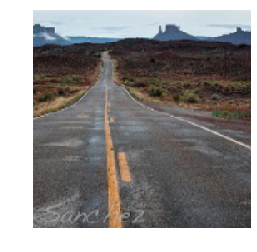

In [62]:
f, w = test_set[0]
f = normalize(f)
w = normalize(w)

print(f.size())

temp_img = torch.cat((f, w), dim = 2)

# print(torch.max(f))
# print(torch.min(f))

myimshow(temp_img)

myimshow(normalize(f))


In [63]:
netG_A2B = Generator(opt.input_nc, opt.output_nc).to(device)
netG_B2A = Generator(opt.output_nc, opt.input_nc).to(device) 
netD_A = Discriminator(opt.input_nc).to(device) 
netD_B = Discriminator(opt.output_nc).to(device) 

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)



Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [64]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()


In [65]:
# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=opt.lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(itertools.chain(netD_A.parameters(), netD_B.parameters()), lr=opt.lr, betas=(0.5, 0.999))

# optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=opt.lr, betas=(0.5, 0.999))



In [66]:
# lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)
# lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)
# lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)



In [67]:
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

train_loader = DataLoader(train_set, batch_size = opt.batchSize, shuffle = True, pin_memory=True)

val_loader = DataLoader(val_set, batch_size = opt.batchSize, shuffle = False, pin_memory=True)

test_loader = DataLoader(test_set, batch_size = opt.batchSize, shuffle = False, pin_memory=True)



netG_A2B, netG_B2A, netD_A, netD_B, opt, train_loader, valid_loader, test_loader, criterion_identity, criterion_GAN, criterion_cycle , optimizer_G, optimizer_D, output_dir


In [80]:
import time
import os
from torchvision.utils import save_image
import sys


class train_module():
    
    def __init__(self, netG_A2B, netG_B2A, netD_A, netD_B, opt, train_loader, valid_loader, test_loader, criterion_identity, criterion_GAN, criterion_cycle , optimizer_G, optimizer_D, output_dir):
        
        loss_G = [[], []]
        loss_G_identity = [[], []]
        loss_G_GAN = [[], []]
        loss_G_cycle = [[], []]
        loss_D = [[], []]
                
#         transform = tv.transforms.Compose([
#                     tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#                 ])
#         lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)

        os.makedirs(output_dir, exist_ok=True)
        checkpoint_path = os.path.join(output_dir, "checkpoint.pth.tar")
        config_path = os.path.join(output_dir, "config.txt")
        
        print(checkpoint_path)
        
        locs = {k: v for k, v in locals().items() if k is not 'self'}
        self.__dict__.update(locs)
        
#         self.lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(self.optimizer_G, lr_lambda=LambdaLR(200, 0, 100).step)
#         self.lr_scheduler_D = torch.optim.lr_scheduler.LambdaLR(self.optimizer_D, lr_lambda=LambdaLR(200, 0, 100).step)
        
        if os.path.isfile(config_path):
            with open(config_path, 'r') as f:
                if f.read()[:-1] != repr(self):
                    raise ValueError(
                    "checkpoint conflicting with the current setting.")
            self.load()
        else:
            self.save()
            
        num_epochs = self.epoch()
        
#         for i in range(num_epoch):
#             self.lr_scheduler_G.step()
#             self.lr_scheduler_D.step()
            
    def setting(self):
        """Returns the setting of the experiment."""
        return {'opt': self.opt,
                'Optimizer_G': self.optimizer_G,
                'Optimizer_D': self.optimizer_D
               }

    def __repr__(self):
        """Pretty printer showing the setting of the experiment. This is what
        is displayed when doing ``print(experiment)``. This is also what is
        saved in the ``config.txt`` file.
        """
        string = ''
        for key, val in self.setting().items():
            string += '{}({})\n'.format(key, val)
            
        return string
    
        '''
        netG_A2B, netG_B2A, netD_A, netD_B, opt, train_loader, 
        valid_loader, test_loader, criterion_identity, criterion_GAN, 
        criterion_cycle , optimizer_G, optimizer_D, output_dir
                loss_G = []
                loss_G_identity = []
                loss_G_GAN = []
                loss_G_cycle = []
                loss_D = []
        '''
    
    def state_dict(self):
        """Returns the current state of the experiment."""
        return {'netG_A2B': self.netG_A2B.state_dict(),
                'netG_B2A': self.netG_B2A.state_dict(),
                'netD_A': self.netD_A.state_dict(),
                'netD_B': self.netD_B.state_dict(),
                'optimizer_G': self.optimizer_G.state_dict(),
                'optimizer_D': self.optimizer_D.state_dict(),
                }

    def load_state_dict(self, checkpoint):
        """Loads the experiment from the input checkpoint."""
        self.netG_A2B.load_state_dict(checkpoint['netG_A2B'])
        self.netG_B2A.load_state_dict(checkpoint['netG_B2A'])
        self.netD_A.load_state_dict(checkpoint['netD_A'])
        self.netD_B.load_state_dict(checkpoint['netD_B'])
        self.optimizer_G.load_state_dict(checkpoint['optimizer_G'])
        self.optimizer_D.load_state_dict(checkpoint['optimizer_D'])
        
        self.loss_G[0] = list(np.load('{}/loss_G.npy'.format(self.output_dir))[0])
        self.loss_G[1] = list(np.load('{}/loss_G.npy'.format(self.output_dir))[1])

        self.loss_G_identity[0] = list(np.load('{}/loss_G_identity.npy'.format(self.output_dir))[0])
        self.loss_G_identity[1] = list(np.load('{}/loss_G_identity.npy'.format(self.output_dir))[1])
        
        self.loss_G_GAN[0] = list(np.load('{}/loss_G_GAN.npy'.format(self.output_dir))[0])
        self.loss_G_GAN[1] = list(np.load('{}/loss_G_GAN.npy'.format(self.output_dir))[1])
        
        self.loss_G_cycle[0] = list(np.load('{}/loss_G_cycle.npy'.format(self.output_dir))[0])
        self.loss_G_cycle[1] = list(np.load('{}/loss_G_cycle.npy'.format(self.output_dir))[1])

        self.loss_D[0] = list(np.load('{}/loss_D.npy'.format(self.output_dir))[0])
        self.loss_D[1] = list(np.load('{}/loss_D.npy'.format(self.output_dir))[1])


    def save(self):
        """Saves the experiment on disk, i.e, create/update the last checkpoint."""
        
        np.save('{}/loss_G'.format(self.output_dir), np.asarray(self.loss_G))
        np.save('{}/loss_G_identity'.format(self.output_dir), np.asarray(self.loss_G_identity))
        np.save('{}/loss_G_GAN'.format(self.output_dir), np.asarray(self.loss_G_GAN))
        np.save('{}/loss_G_cycle'.format(self.output_dir), np.asarray(self.loss_G_cycle))
        np.save('{}/loss_D'.format(self.output_dir), np.asarray(self.loss_D))
        
        torch.save(self.state_dict(), self.checkpoint_path)
        with open(self.config_path, 'w') as f:
            print(self, file=f)

    def load(self):
        """Loads the experiment from the last checkpoint saved on disk."""
        checkpoint = torch.load(self.checkpoint_path,
                                map_location=self.opt.cuda)
        self.load_state_dict(checkpoint)
        del checkpoint

    def epoch(self):
        """Returns the number of epochs already performed."""
        return len(self.loss_G[0])

    def train(self, num_epochs):
        batch_size = self.opt.batchSize
        start_epoch = self.epoch()
#         for i in range(start_epoch):
#             self.lr
        print('start form {} epoch'.format(start_epoch) )
        Tensor = torch.cuda.FloatTensor if self.opt.cuda else torch.Tensor
        input_A = Tensor(self.opt.batchSize, self.opt.input_nc, self.opt.size, self.opt.size)
        input_B = Tensor(self.opt.batchSize, self.opt.output_nc, self.opt.size, self.opt.size)

        target_real = Variable(Tensor(self.opt.batchSize).fill_(1.0), requires_grad=False)
        target_fake = Variable(Tensor(self.opt.batchSize).fill_(0.0), requires_grad=False)
        
        if not os.path.exists('{}/train'.format(self.output_dir)):
            os.makedirs('{}/train'.format(self.output_dir))

        for iter_epoch in range(start_epoch, num_epochs):
            start_time = time.time()
            temp_loss_G = 0
            temp_loss_G_identity = 0
            temp_loss_G_GAN = 0
            temp_loss_G_cycle = 0
            temp_loss_D = 0
            for i, batch in enumerate(self.train_loader):
                print('{}th batch in {} epoch'.format(i, iter_epoch))
                real_A = Variable(input_A.copy_(batch[0])) # flickr
                real_B = Variable(input_B.copy_(batch[1])) # wikiart
                
                self.optimizer_G.zero_grad()
                # Generators 
                # identity loss
                loss_identity_B_ = self.criterion_identity(self.netG_A2B(real_B), real_B)*5.0
                loss_identity_A_ = self.criterion_identity(self.netG_B2A(real_A), real_A)*5.0
                
                # GAN loss
                fake_B = self.netG_A2B(real_A)
                loss_GAN_A2B_ = self.criterion_GAN(self.netD_B(fake_B), target_real)

                fake_A = self.netG_B2A(real_B)
                loss_GAN_B2A_ = self.criterion_GAN(self.netD_A(fake_A), target_real)

                # Cycle loss
                loss_cycle_ABA_ = self.criterion_cycle(self.netG_B2A(fake_B), real_A)*10.0
                loss_cycle_BAB_ = self.criterion_cycle(self.netG_A2B(fake_A), real_B)*10.0

                # Total G loss
                loss_G_ = loss_identity_A_ + loss_identity_B_ + loss_GAN_A2B_ + loss_GAN_B2A_ + loss_cycle_ABA_ + loss_cycle_BAB_
  
                loss_G_.backward()
                self.optimizer_G.step()
        
                # Discriminator
                self.optimizer_D.zero_grad()
                loss_D_real_ = self.criterion_GAN(self.netD_A(real_A), target_real)
                loss_D_fake_ = self.criterion_GAN(self.netD_A(fake_A_buffer.push_and_pop(fake_A).detach()), target_fake)
                loss_D_A_ = (loss_D_real_ + loss_D_fake_)*0.5
                loss_D_A_.backward()
    
                loss_D_real_ = self.criterion_GAN(self.netD_B(real_B), target_real)
                loss_D_fake_ = self.criterion_GAN(self.netD_B(fake_B_buffer.push_and_pop(fake_B).detach()), target_fake)
                loss_D_B_ = (loss_D_real_ + loss_D_fake_)*0.5
                loss_D_B_.backward()
                
                self.optimizer_D.step()
                
                temp_loss_G += loss_G_.item()
                temp_loss_D += loss_D_A_.item() + loss_D_B_.item()
                temp_loss_G_cycle += loss_cycle_ABA_.item() + loss_cycle_BAB_.item()
                temp_loss_G_GAN += loss_GAN_A2B_.item() + loss_GAN_B2A_.item()
                temp_loss_G_identity += loss_identity_A_.item() + loss_identity_B_.item()
                
                if i % 100 == 0 and i != 0:
                     print('complete {}batch in epoch {}, loss_G={}, loss_D={}, loss_G_GAN={}, \
                loss_G_cycle={}, loss_G_identity={}'.format(i, iter_epoch,  \
                temp_loss_G/i/batch_size, temp_loss_D/i/batch_size, temp_loss_G_cycle/i/batch_size, \
                temp_loss_G_GAN/i/batch_size, temp_loss_G_identity/i/batch_size))
                
            self.loss_G[0].append(temp_loss_G/i/batch_size)
            self.loss_D[0].append(temp_loss_D/i/batch_size)
            self.loss_G_GAN[0].append(temp_loss_G_GAN/i/batch_size)
            self.loss_G_cycle[0].append(temp_loss_G_cycle/i/batch_size)
            self.loss_G_identity[0].append(temp_loss_G_identity/i/batch_size)
            
            print('complete training in epoch {}, loss_G={}, loss_D={}, loss_G_GAN={}, \
                loss_G_cycle={}, loss_G_identity={}'.format(iter_epoch,  \
                self.loss_G[0][-1], self.loss_D[0][-1], self.loss_G_GAN[0][-1], self.loss_G_cycle[0][-1], self.loss_G_identity[0][-1]))
            
            real_A_data = 0.5*(real_A.data + 1.0)
            real_B_data = 0.5*(real_B.data + 1.0)
            
            fake_A_data = 0.5*(fake_A.data + 1.0)
            fake_B_data = 0.5*(fake_B.data + 1.0)
            
            for iter_i in range(self.opt.batchSize):
                save_image(torch.cat((real_A_data[iter_i], fake_A_data[iter_i], real_B_data[iter_i], fake_B_data[iter_i]), dim=2), '{}/train/epoch{}_{}.png'.format(self.output_dir, iter_epoch, iter_i))

            self.validation(iter_epoch)

            print("Epoch {} (Time: {:.2f}s)".format(
                iter_epoch, time.time() - start_time))
            
            self.save()
            
#             self.lr_scheduler_G.step()
#             self.lr_scheduler_D.step()
            
            self.plot_loss()

    def validation(self, iter_epoch):
        with torch.no_grad():
            batch_size = self.opt.batchSize
            Tensor = torch.cuda.FloatTensor if self.opt.cuda else torch.Tensor
            input_A = Tensor(self.opt.batchSize, self.opt.input_nc, self.opt.size, self.opt.size)
            input_B = Tensor(self.opt.batchSize, self.opt.output_nc, self.opt.size, self.opt.size)
            target_real = Variable(Tensor(self.opt.batchSize).fill_(1.0), requires_grad=False)
            target_fake = Variable(Tensor(self.opt.batchSize).fill_(0.0), requires_grad=False)

            temp_loss_G = 0
            temp_loss_G_identity = 0
            temp_loss_G_GAN = 0
            temp_loss_G_cycle = 0
            temp_loss_D = 0

            if not os.path.exists('{}/val'.format(self.output_dir)):
                os.makedirs('{}/val'.format(self.output_dir))

            for i, batch in enumerate(self.valid_loader):
                real_A = Variable(input_A.copy_(batch[0])) # flickr
                real_B = Variable(input_B.copy_(batch[1])) # wikiart
                
                # Generators 
                # identity loss
                loss_identity_B_ = self.criterion_identity(self.netG_A2B(real_B), real_B)*5.0
                loss_identity_A_ = self.criterion_identity(self.netG_B2A(real_A), real_A)*5.0
                
                # GAN loss
                fake_B = self.netG_A2B(real_A)
                loss_GAN_A2B_ = self.criterion_GAN(self.netD_B(fake_B), target_real)

                fake_A = self.netG_B2A(real_B)
                loss_GAN_B2A_ = self.criterion_GAN(self.netD_A(fake_A), target_real)

                # Cycle loss
                loss_cycle_ABA_ = self.criterion_cycle(self.netG_B2A(fake_B), real_A)*10.0
                loss_cycle_BAB_ = self.criterion_cycle(self.netG_A2B(fake_A), real_B)*10.0

                # Total G loss
                loss_G_ = loss_identity_A_ + loss_identity_B_ + loss_GAN_A2B_ + loss_GAN_B2A_ + loss_cycle_ABA_ + loss_cycle_BAB_

                # Discriminator
                loss_D_real_ = self.criterion_GAN(self.netD_A(real_A), target_real)
                loss_D_fake_ = self.criterion_GAN(self.netD_A(fake_A_buffer.push_and_pop(fake_A).detach()), target_fake)
                loss_D_A_ = (loss_D_real_ + loss_D_fake_)*0.5

                loss_D_real_ = self.criterion_GAN(self.netD_B(real_B), target_real)
                loss_D_fake_ = self.criterion_GAN(self.netD_B(fake_B_buffer.push_and_pop(fake_B).detach()), target_fake)
                loss_D_B_ = (loss_D_real_ + loss_D_fake_)*0.5
                                
                temp_loss_G += loss_G_.item()
                temp_loss_D += loss_D_A_.item() + loss_D_B_.item()
                temp_loss_G_cycle += loss_cycle_ABA_.item() + loss_cycle_BAB_.item()
                temp_loss_G_GAN += loss_GAN_A2B_.item() + loss_GAN_B2A_.item()
                temp_loss_G_identity += loss_identity_A_.item() + loss_identity_B_.item()
            
            self.loss_G[1].append(temp_loss_G/i/batch_size)
            self.loss_D[1].append(temp_loss_D/i/batch_size)
            self.loss_G_GAN[1].append(temp_loss_G_GAN/i/batch_size)
            self.loss_G_cycle[1].append(temp_loss_G_cycle/i/batch_size)
            self.loss_G_identity[1].append(temp_loss_G_identity/i/batch_size)

            real_A_data = 0.5*(real_A.data + 1.0)
            real_B_data = 0.5*(real_B.data + 1.0)

            fake_A_data = 0.5*(fake_A.data + 1.0)
            fake_B_data = 0.5*(fake_B.data + 1.0)
            
            for iter_i in range(self.opt.batchSize):
                save_image(torch.cat((real_A_data[iter_i], fake_A_data[iter_i], real_B_data[iter_i], fake_B_data[iter_i]), dim=2), '{}/val/epoch{}_{}.png'.format(self.output_dir, iter_epoch, iter_i))


            print('validation, loss_G={}, loss_D={}, loss_G_GAN={}, \
                loss_G_cycle={}, loss_G_identity={}'.format( \
                self.loss_G[1][-1], self.loss_D[1][-1], self.loss_G_GAN[1][-1], self.loss_G_cycle[1][-1], self.loss_G_identity[1][-1]))
    
    def normalize(self, data):

        return (data - torch.min(data))/(torch.max(data)-torch.min(data))

    def test(self):
        self.netG_A2B.eval()
        self.netG_B2A.eval()

        Tensor = torch.cuda.FloatTensor if self.opt.cuda else torch.Tensor
        input_A = Tensor(self.opt.batchSize, self.opt.input_nc, self.opt.size, self.opt.size)
        input_B = Tensor(self.opt.batchSize, self.opt.output_nc, self.opt.size, self.opt.size)
        
        if not os.path.exists('{}/test'.format(self.output_dir)):
            os.makedirs('{}/test'.format(self.output_dir))

        for i, batch in enumerate(self.test_loader):#test_loader
            # Set model input
            img_list = []
            real_A = Variable(input_A.copy_(batch[0]))
            real_B = Variable(input_B.copy_(batch[1]))

            # Generate output
            fake_B = self.netG_A2B(real_A).data
            fake_A = self.netG_B2A(real_B).data

            save_image(torch.cat((self.normalize(real_A.data[0]), self.normalize(fake_A[0]), \
                                  self.normalize(real_B.data[0]), self.normalize(fake_B[0])), \
                                 dim=2), '{}/test/{}.png'.format(self.output_dir, i))

            sys.stdout.write('\rGenerated images %04d of %04d' % (i+1, len(test_loader)))

        sys.stdout.write('\n')        
    
    def demo(self):
        self.netG_A2B.eval()
        self.netG_B2A.eval()

        Tensor = torch.cuda.FloatTensor if self.opt.cuda else torch.Tensor
        input_A = Tensor(self.opt.batchSize, self.opt.input_nc, self.opt.size, self.opt.size)
        input_B = Tensor(self.opt.batchSize, self.opt.output_nc, self.opt.size, self.opt.size)
        
        img_out_list = []
        
        for i, batch in enumerate(self.test_loader):#test_loader
            # Set model input
            img_list = []
            real_A = Variable(input_A.copy_(batch[0]))
            real_B = Variable(input_B.copy_(batch[1]))

            # Generate output
            fake_B = self.netG_A2B(real_A).data
            fake_A = self.netG_B2A(real_B).data

            img_out_list.append(torch.cat((self.normalize(real_A.data[0]), self.normalize(fake_A[0]), \
                                  self.normalize(real_B.data[0]), self.normalize(fake_B[0])), \
                                 dim=2).cpu().detach().numpy())
            if i > 6:
                break
                
        for j in range(len(img_out_list)):
            img_out_list[j] = np.moveaxis(img_out_list[j], [0, 1, 2], [2, 0, 1]) 
        temp_img = np.concatenate(img_out_list, axis = 0)
        plt.figure(figsize=(35,17))

        plt.imshow(temp_img)
        plt.axis('off')
        plt.show()

    def save_show_test_images(self):
        test_out_dir = self.output_dir + '/test'
        files_files = os.listdir(test_out_dir)
        idx_list = []
        a = 6
        for idx in range(a, a+6):
            idx_list.append(os.path.join(test_out_dir, files_files[idx]))
        img_list = []
        for item in idx_list:
            img_list.append(np.array(Image.open(item)))
        
        print(img_list[0].shape)
        
        return img_list
    
    def plot_loss(self):

        if not os.path.exists('{}/loss'.format(self.output_dir)):
            os.makedirs('{}/loss'.format(self.output_dir))
        epoch_list = range(self.epoch())
        
        loss_name = ['loss_G', 'loss_D', 'loss_G_GAN', 'loss_G_cycle', 'loss_G_identity']

        loss_list = [self.loss_G, self.loss_D, self.loss_G_GAN, self.loss_G_cycle, self.loss_G_identity]

        for i in range(len(loss_list)):

            fig = plt.figure(figsize = (15, 8))
            plt.plot(epoch_list, loss_list[i][0], label='Training set loss')
            plt.plot(epoch_list, loss_list[i][1], label='validation set loss')
            plt.legend(loc='upper right')
            plt.title('{}'.format(loss_name[i]), fontsize=20)
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            fig.savefig('{}/loss/{}.png'.format(self.output_dir, loss_name[i]))
            plt.close()



In [81]:

exp0 = train_module(netG_A2B, netG_B2A, netD_A, netD_B, opt, train_loader, \
                    val_loader, test_loader, criterion_identity, \
                    criterion_GAN, criterion_cycle , optimizer_G, \
                    optimizer_D, output_dir = 'check3')



check3/checkpoint.pth.tar


In [82]:
# exp0.train(num_epochs=200)


In [83]:
# exp0.test()

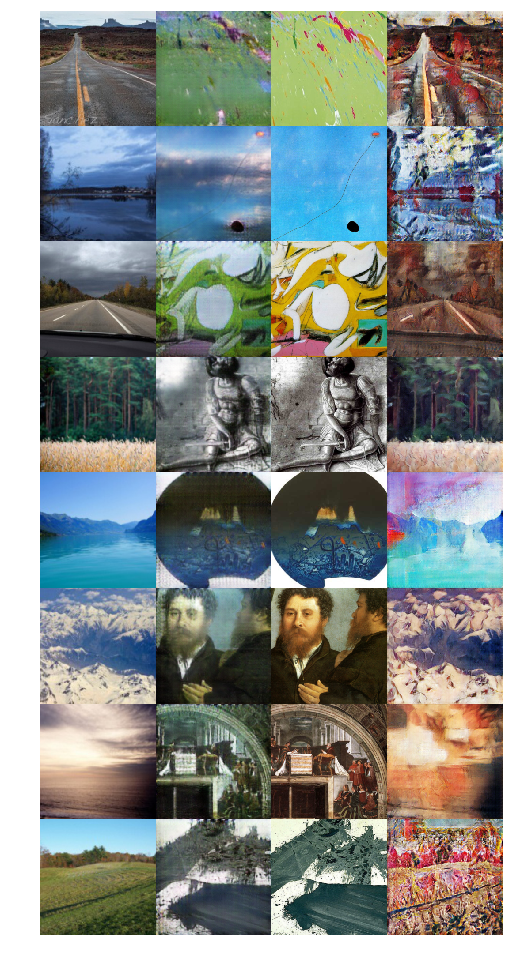

In [84]:
exp0.demo()

In [49]:
img = exp0.save_show_test_images()

(262, 1048, 3)
